<a href="https://colab.research.google.com/github/wenxuan0923/My-notes/blob/master/DL_univariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series forecasting
### - Temperature prediction

This note will cover topics about:
-  Convert univariate time series data into DL dataset using self-defined generator
- One-step v.s. Multi-step forecasting
- Regularization methods for RNN model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, GRU

Using TensorFlow backend.


The temperature dataset used in this note can be found [here](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip). It has 420,551 lines of data, each line is a timestep: a record of a date and 14 weather-related values. Note the temperature is recorded evey 10 minutes. For a single hour you will have 6 observations. Similarly, a single day will contain 144 (24\*6) observations. 

In [2]:
temperature_df = pd.read_csv('jena_climate_2009_2016.csv')
temperature_df = temperature_df.set_index('Date Time')
temperature_df.index = pd.to_datetime(temperature_df.index, 
                                      format="%d.%m.%Y %H:%M:%S")
temperature_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Univariate Time Series
Let's try only use the temperature **T (degC)** itself for prediction in this note:


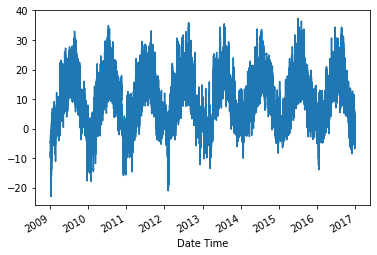

In [94]:
uni_ts = temperature_df['T (degC)']
uni_ts.plot()
plt.show()

### Prepare the data

To get the data ready for modelling, we need to:
* Normalize the data
* Convert the dataframe into a 2D tensor of shape (timesteps, features)
* Get ready a training and validation set


A supervised learning algorithm requires that data is provided as a collection of samples, where each sample has an input (x) and an output (y). We need to transform the time series data into a supervised learning dataset.

**For example**: To make one-step prediction using past 3 days data for time series = [1, 2, 3, 4, 5, 6, 7, 8, 9]

We want the data to be in the format:

[1,2,3] $\Rightarrow$ [4] <br>
[2,3,4] $\Rightarrow$ [5] <br>
[3,4,5] $\Rightarrow$ [6] <br>
[4,5,6] $\Rightarrow$ [7] <br>
$\vdots$ 

Similarly, To make three-step prediction using past 2 days data for the same time series, we want the data to be in the format:

[1,2] $\Rightarrow$ [5] <br>
[2,3] $\Rightarrow$ [6] <br>
[3,4] $\Rightarrow$ [7] <br>
[4,5] $\Rightarrow$ [8] <br>
$\vdots$ 

To do this, we need to define a generator function:


In [0]:
def generator(data, look_back, pred_step, min_index, max_index,
                shuffle=False, batch_size=1, step=1):
    if max_index is None:
        max_index = len(data) - pred_step
    # i represents batch
    i = min_index + look_back
    while True:
        if shuffle:
            rows = np.random.randint(
                    min_index + look_back, max_index, size=batch_size)
        else:
            if i + batch_size > max_index:
                i = min_index + look_back    # start over
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            look_back // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))

        # j represents sample
        for j, row in enumerate(rows):
            indices = range(rows[j] - look_back, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + pred_step][0]
        yield samples, targets

Note: in `range()` and `lst[:]` the right limit is not included.
 

- **data**: The original array of floating-point data of shape (timesteps, features)
- **look_back**: How many timesteps back the input data should go
- **pred_step**: How many timesteps in the future the target should be
- **min_index** and **max_index**: Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
- **shuffle**: Whether to shuffle the samples or draw them in chronological order
- **batch_size**: The number of samples per batch
- **step**: The period, in timesteps, at which you sample data. 

**This function can be illustrated by the image below:**

<center><img src='https://drive.google.com/uc?id=1SCd0rbpJL4DQL871mZf2BVLwAhW5TJDu' width=400></img></center>

At index t:
- input data is: $[x_{(t-\text{look_back})},...,x_{t-2},x_{t-1}]$
- output target is: $[x_{(t+\text{pred_step})}]$





#### Example:


In [115]:
example_ts = np.array([1,2,3,4,5,6,7,8,9])
example_ts = example_ts.reshape(-1,1)   # univatriate data: only 1 feature
pred_step = 2   # 3-step prediction
look_back = 3   # look back 3 data points for each prediction
example_gen = generator(example_ts, look_back, pred_step, 
                        min_index=0, max_index=None)
i = 0
while i <= 3:
  display(next(example_gen))
  i += 1

(array([[[1.],
         [2.],
         [3.]]]), array([6.]))

(array([[[2.],
         [3.],
         [4.]]]), array([7.]))

(array([[[3.],
         [4.],
         [5.]]]), array([8.]))

(array([[[4.],
         [5.],
         [6.]]]), array([9.]))

Illustration for this example:

<center><img src='https://drive.google.com/uc?id=1LFkGPk8iwLY6ZsOCP8eWoaTej4iKXuHP' width=600></img></center>

Let's use the first 300,000 rows of the data as training dataset, and there remaining as the validation dataset. 

This amounts to ~2100 days worth of training data.

In [0]:
TRAIN_SPLIT = 300000
# Convert pd.Series into numpt array of floating value
uni_data = uni_ts.values 
# Only use the training data for normalization
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For this univariate model, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step.

In [0]:
uni_data = uni_data.reshape(-1, 1)
look_back = 20
pred_step = 0
BATCH_SIZE = 256

train_gen = generator(uni_data, 
                      look_back, 
                      pred_step, 
                      min_index=0, 
                      max_index=TRAIN_SPLIT,
                      batch_size=BATCH_SIZE)

val_gen = generator(uni_data, 
                    look_back, 
                    pred_step, 
                    min_index=TRAIN_SPLIT+1,
                    max_index=None,
                    batch_size=BATCH_SIZE)

Let's take a look at a single data point in your training set:

In [109]:
first_train_data = next(train_gen) # whole batch: 256 data points
print(len(first_train_data[0]))  # input data 
print(len(first_train_data[1]))  # target value data

256
256


In [110]:
first_train_data[0][0]  # each sample has 20 data points (size=look_back)

array([[-1.99766294],
       [-2.04281897],
       [-2.05439744],
       [-2.0312405 ],
       [-2.02660912],
       [-2.00113649],
       [-1.95134907],
       [-1.95134907],
       [-1.98492663],
       [-2.04513467],
       [-2.08334362],
       [-2.09723778],
       [-2.09376424],
       [-2.09144854],
       [-2.07176515],
       [-2.07176515],
       [-2.07639653],
       [-2.08913285],
       [-2.09260639],
       [-2.10418486]])

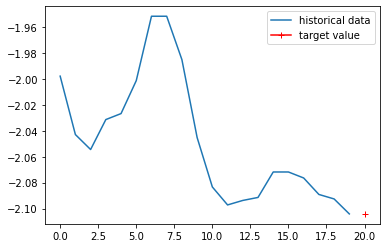

In [111]:
plt.plot(range(len(first_train_data[0][0])), first_train_data[0][0], label='historical data')
plt.plot(len(first_train_data[0][0]) + pred_step, first_train_data[1][0],
         color='red', marker='+', label='target value')
plt.legend()
plt.show()

### A GRU model for time series forecast

In [0]:
model = Sequential()
model.add(layers.GRU(64,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, uni_data.shape[-1])))
model.add(layers.Dense(1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

In [127]:
history = model.fit_generator(train_gen,
                              epochs=15,
                              steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE,
                              validation_data=val_gen,
                              validation_steps=(len(uni_data)-TRAIN_SPLIT)//BATCH_SIZE)

Epoch 1/15
1171/1171 [==============================] - 70s 60ms/step - loss: 0.2203 - val_loss: 0.2838
Epoch 2/15
1171/1171 [==============================] - 69s 59ms/step - loss: 0.1894 - val_loss: 0.2201
Epoch 3/15
1171/1171 [==============================] - 69s 59ms/step - loss: 0.1847 - val_loss: 0.1882
Epoch 4/15
1171/1171 [==============================] - 69s 59ms/step - loss: 0.1816 - val_loss: 0.1691
Epoch 5/15
1171/1171 [==============================] - 70s 59ms/step - loss: 0.1796 - val_loss: 0.2098
Epoch 6/15
1171/1171 [==============================] - 75s 64ms/step - loss: 0.1809 - val_loss: 0.1999
Epoch 7/15
1171/1171 [==============================] - 70s 60ms/step - loss: 0.1793 - val_loss: 0.2106
Epoch 8/15
1171/1171 [==============================] - 70s 60ms/step - loss: 0.1802 - val_loss: 0.2083
Epoch 9/15
1171/1171 [==============================] - 70s 60ms/step - loss: 0.1798 - val_loss: 0.2095
Epoch 10/15
1171/1171 [==============================] - 70s 60m

By setting:

 `steps_per_epoch = TotalTrainingSamples // TrainingBatchSize`

`validation_steps = TotalvalidationSamples // ValidationBatchSize`

It makes sure that at each epoch:

- You train on exactly your entire training set
- You validate on exactly your entire validation set

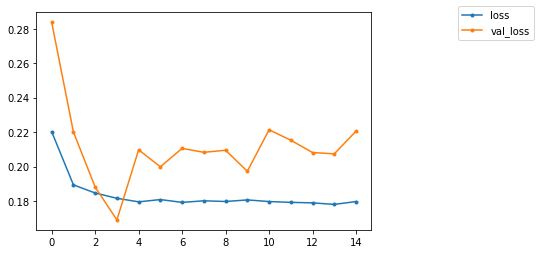

In [128]:
ax = pd.DataFrame(history.history)[['loss', 'val_loss']].plot(marker='.')
ax.legend(bbox_to_anchor=(1.5, 1.05))
plt.show()

Useful Reference:

1. [How to Use the TimeseriesGenerator for Time Series Forecasting in Keras](
https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/)

2. [TensorFlow tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)

3. [steps_per_epoch v.s. validation_steps](https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list)